In [ ]:
!pip install xgboost
! pip install gplearn

In [ ]:
import numpy as np
import pandas as pd
import csv
import re
from matplotlib import pyplot as plt

from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
data = pd.read_excel('/content/dataset_version_aug_11th.xlsx')
secure_mask = (data['High Severity'] == 0) & (data['Medium Severity'] == 0) & (data['Critical Severity'] == 0) & (data['Low Severity'] < 50) & data['name of base images'].isnull()
data.loc[secure_mask, 'secure'] = 1
data = data[data['secure'] == 1]

dataset = pd.read_excel('/content/docker_images_pull_scan_inspect_dataset_Aug_6th.xlsx')
dataset_search = pd.read_excel('/content/docker_images_pull_scan_inspect_search_images_dataset.xlsx')


df = pd.concat([dataset, dataset_search, data], axis = 0)
secure_mask = (df['High Severity'] == 0) & (df['Medium Severity'] == 0) & (df['Critical Severity'] == 0) & (df['Low Severity'] < 50) & df['name of base images'].isnull()
df.loc[secure_mask, 'secure'] = 1


df = df.drop(columns = ['image_id','Docker Name', 'architecture',  'exposed_ports',
       'env_variables', 'labels', 'health_check', 'entrypoint', 'volumes',
       'user', 'working_dir', 'cmd', 'exposed_directories', 'configurations',
       'operating_system', 'author', 'license_info', 'documentation', 'name of base images',  'created_date', 'Number of Pulls', 'search'], axis = 0)
nan_counts = df.isna().sum(axis=1)
df.drop_duplicates()

# Drop rows with a specific number of NaN values
threshold_nans = 14
filtered_df = df[nan_counts < threshold_nans]
print(filtered_df)

# Define a function to replace NaN values with mode for a column
def replace_with_mode(column):
    mode_value = column.mode()[0]
    return column.fillna(mode_value)

         Tag Last Update    Size Package Manager     Base Image  \
4     latest      9 days   250MB             deb    debian:11.7   
5     latest   22 months   472MB             deb   ubuntu:20.04   
9     latest     2 weeks   184MB             rpm            NaN   
11      3.16     7 weeks  5.54MB             apk  alpine:3.16.6   
13      3.16     7 weeks  5.54MB             apk  alpine:3.18.2   
...      ...         ...     ...             ...            ...   
1125  latest   21 months  6.91MB           linux            NaN   
1133    3.16      4 days  5.54MB             apk  alpine:3.18.3   
1134  latest      6 days  94.2MB             apk            NaN   
1136  latest      6 days  46.5MB             apk            NaN   
1138  latest      6 days  68.5MB             apk            NaN   

      # alternative base imgs  number of tested dependencies  \
4                        12.0                          152.0   
5                         0.0                          132.0   
9  

In [ ]:
df.columns

Index(['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       '# alternative base imgs', 'number of tested dependencies',
       'number of vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers', 'secure'],
      dtype='object')

In [ ]:


#filtered_df.to_excel('/content/drive/MyDrive/Docker_Images_Features.xlsx')
#/content/docker_images_pull_scan_inspect_search_images_dataset.xlsx

In [ ]:

# Define a function to replace NaN values with mode for a column
def replace_with_mode(column):
    mode_value = column.mode()[0]
    return column.fillna(mode_value)

secure
0.0    468
1.0    310
Name: count, dtype: int64


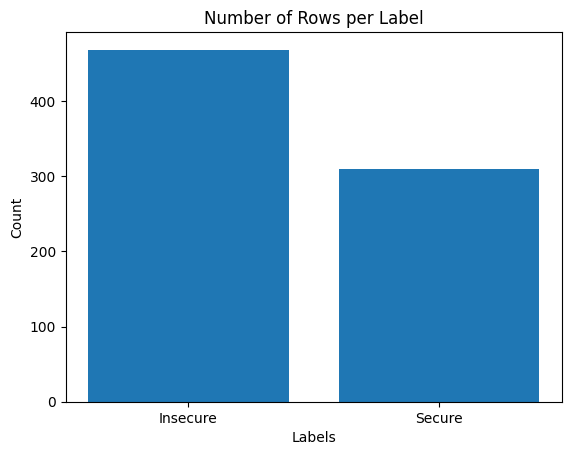

In [ ]:
df = filtered_df
# Count the number of rows per label
label_counts = df["secure"].value_counts()
print(label_counts)
# Create a bar plot of the label counts
plt.bar(label_counts.index, label_counts.values)

# modify the x-axis tick labels
plt.xticks([0, 1], ["Insecure", "Secure"])
# Add title and labels to the plot
plt.title("Number of Rows per Label")
plt.xlabel("Labels")
plt.ylabel("Count")

# Display the plot
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Parse the string
def extract_value(x):
    m = re.match(r'(\d+)([KMG]B)', x)
    if m:
        value = float(m.group(1))
        unit = m.group(2)
        print(m)
        return value, unit
    else:
        return x

# Step 2: Convert to bytes
def convert_to_bytes(x):
    if x[0] is not None and x[1] is not None:
        if x[1] == 'KB':
            return float(x[0] * 1024)
        elif x[1] == 'MB':
            return float(x[0] * 1024 * 1024)
        elif x[1] == 'GB':
            return float(x[0] * 1024 * 1024 * 1024)
        elif x[1] == 'B':
            return float(x[0] * 1024)
    else:
        return float(x)


# Function to convert different time units to days
def convert_to_days(value):
    units = {
        "year": 365,
        "years": 365,
        "month": 30,
        "months": 30,
        'weeks': 7,
        'weeks':7,
        "day": 1,
        "days": 1,
        "hour": 1 / 24,
        "hours": 1 / 24,
        "minute": 1 / (24 * 60),
        "minutes": 1 / (24 * 60),
        "second": 1 / (24 * 60 * 60),
        "seconds": 1 / (24 * 60 * 60),
        }
    try:
        num, unit = value.split()
        num = float(num)
        unit = unit.strip().lower()
        return num * units[unit]
    except (ValueError, AttributeError):
      if value == 'About an':
        return 0

      return value

def preprocess(df):
  # Convert the column to string format
  df['Size'] = df['Size'].astype(str)

  df['Size'] = df['Size'].apply(lambda x: extract_value(x))

  df['Size'] = df['Size'].apply(lambda x: convert_to_bytes(x))

  # Step 3: Normalize the values
  max_value = df['Size'].max()
  df['Size'] = df['Size'] / max_value

  # Step 4: Scale the values between 0 and 1
  scaler = MinMaxScaler()
  df['Size'] = scaler.fit_transform(df[['Size']])

  # Perform label encoding on the 'category' column
  le = LabelEncoder()

  df['Package Manager'] = df['Package Manager'].astype(str)
  df['Package Manager'] = le.fit_transform(df['Package Manager'])

  #dataset['Base Image'] = dataset['Base Image'].str.split(':', expand=True)[0]
  df['Base Image'] = le.fit_transform(df['Base Image'])

  df['Tag'] = df['Tag'].astype(str)
  df['Tag'] = le.fit_transform(df['Tag'])

  '''# Update the "secure" column
  for index, row in dataset.iterrows():
      if row['secure'] == 'Yes':
          dataset.loc[index, "secure"] = 1
      elif row['secure'] == 'No':
          dataset.loc[index, "secure"] = 0
      elif row['secure'] == '1':
          dataset.loc[index, "secure"] = 1
      elif row['secure'] == '0':
          dataset.loc[index, "secure"] = 0
  '''
  #dataset.dropna(how='all', inplace=True)

  # Apply the function to the "Change On" column and create a new column with the days
  df['Last Update'] = df['Last Update'].apply(convert_to_days)

  # Scale the "Change On (days)" column using Min-Max scaling
  scaler = MinMaxScaler()
  df['Last Update'] = scaler.fit_transform(df[['Last Update']])
  return df


In [ ]:
df = preprocess(df)
for column in df.columns:
    df[column].fillna(0, inplace=True)

X = df.drop(columns=['secure'], axis = 1).values
y = df['secure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
df

<re.Match object; span=(0, 5), match='250MB'>
<re.Match object; span=(0, 5), match='472MB'>
<re.Match object; span=(0, 5), match='184MB'>
<re.Match object; span=(0, 5), match='114MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='119MB'>
<re.Match object; span=(0, 5), match='253MB'>
<re.Match object; span=(0, 5), match='117MB'>
<re.Match object; span=(0, 5), match='155MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='144MB'>
<re.Match object; span=(0, 5), match='427MB'>
<re.Match object; span=(0, 5), match='666MB'>
<re.Match object; span=(0, 5), match='261MB'>
<re.Match object; span=(0, 5), match='428MB'>
<re.Match object; span=(0, 5), match='510MB'>
<re.Match object; span=(0, 5), match='432MB'>
<re.Match object; span=(0, 5), match='408MB'>
<re.Match object; span=(0, 5), match='383MB'>
<re.Match object; span=(0, 5), match='574MB'>
<re.Match object; span=(0, 5), match='167MB'>
<re.Match object; span=(0, 5), mat

<ipython-input-7-3ea678cb0029>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(0, inplace=True)


,Tag,Last Update,Size,Package Manager,Base Image,# alternative base imgs,number of tested dependencies,number of vulnerabilities,Critical Severity,High Severity,Medium Severity,Low Severity,layers,secure
4,50,0.002911,0.235294,1,44,12.0,152.0,66.0,0.0,0.0,0.0,66.0,7.0,0.0
5,50,0.225895,0.464396,1,129,0.0,132.0,131.0,0.0,5.0,72.0,54.0,3.0,0.0
9,50,0.004624,0.167183,3,135,0.0,150.0,7.0,0.0,0.0,7.0,0.0,1.0,0.0
11,25,0.016612,0.000000,0,9,0.0,14.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0
13,25,0.016612,0.000000,0,14,0.0,15.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,50,0.215619,0.000000,2,135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
1133,25,0.001199,0.000000,0,15,0.0,15.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1134,50,0.001884,0.000000,0,135,0.0,19.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1136,50,0.001884,0.000000,0,135,0.0,26.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Assuming X and y are your features and target variable, respectively

# Create a Logistic Regression model
model = DecisionTreeClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
print("Accuracy:", model.score(X_test, y_test))

range_actual_values = max(y_test) - min(y_test)
# Calculate Mean Squared Error (MSE)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))
# Extract TP, TN, FP, FN
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix and individual values
print("Confusion Matrix:")
print(conf_matrix)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)



Accuracy: 0.9846153846153847
Accuracy: 0.98
Precision: 0.99
Recall: 0.98
F1 Score: 0.98
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       111
         1.0       0.99      0.98      0.98        84

    accuracy                           0.98       195
   macro avg       0.99      0.98      0.98       195
weighted avg       0.98      0.98      0.98       195

Confusion Matrix:
[[110   1]
 [  2  82]]

True Positives: 82
True Negatives: 110
False Positives: 1
False Negatives: 2


### **prediction of 9 images**

In [ ]:
df_p = pd.read_excel('/content/predict_imgs (1).xlsx')
new_column_names = {
    'Tag': 'Tag',
    'Last Update': 'Last Update',
    'Size': 'Size',
    'Package Manager': 'Package Manager',
    'Base Image': 'Base Image',
    '# alternative base imgs': 'Number of Alternative Base Images',
    'number of tested dependencies': 'Number of Tested Dependencies',
    'number of vulnerabilities': 'Number of Vulnerabilities',
    'Critical Severity': 'Critical Severity',
    'High Severity': 'High Severity',
    'Medium Severity': 'Medium Severity',
    'Low Severity': 'Low Severity',
    'layers': 'Layers',
    'secure': 'Labels'
}

df_p.rename(columns=new_column_names, inplace=True)

df_p.to_excel('/content/drive/MyDrive/Predict_Docker_Images_Dataset.xlsx')

In [ ]:
df_p['Actual Labels'] = df_p['secure ']
df_p['Predicted Labels/ RF'] = v
df_p.to_excel('/content/drive/MyDrive/Docker_Images_For_Predict_RF_with_Prediction_Values.xlsx')

In [ ]:
dfp = df_p.drop(columns= ['Docker Name', 'secure '])
dfp1=  preprocess(dfp)
print(dfp1)
dfp1.dropna()
v = rfc.predict(dfp1.dropna())

print(df_p['secure '], v)

<re.Match object; span=(0, 5), match='527MB'>
<re.Match object; span=(0, 5), match='670MB'>
<re.Match object; span=(0, 5), match='225MB'>
<re.Match object; span=(0, 3), match='8GB'>
<re.Match object; span=(0, 4), match='86MB'>
<re.Match object; span=(0, 5), match='386MB'>
<re.Match object; span=(0, 5), match='906MB'>
<re.Match object; span=(0, 5), match='831MB'>
<re.Match object; span=(0, 3), match='6MB'>
<re.Match object; span=(0, 4), match='94MB'>
   Tag  Last Update      Size  Package Manager  Base Image  \
0    3     1.000000  0.063645                1           0   
1    3     1.000000  0.081114                1           0   
2    1     0.000023  0.026753                2           0   
3    2     0.000480  1.000000                2           0   
4    3     0.011485  0.009773                2           1   
5    3     0.000000  0.046421                2           0   
6    3     0.000503  0.109944                2           0   
7    3     0.000526  0.100782                2    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_column_names = {
    'Tag': 'Tag',
    'Last Update': 'Last Update',
    'Size': 'Size',
    'Package Manager': 'Package Manager',
    'Base Image': 'Base Image',
    '# alternative base imgs': 'Number of Alternative Base Images',
    'number of tested dependencies': 'Number of Tested Dependencies',
    'number of vulnerabilities': 'Number of Vulnerabilities',
    'Critical Severity': 'Critical Severity',
    'High Severity': 'High Severity',
    'Medium Severity': 'Medium Severity',
    'Low Severity': 'Low Severity',
    'layers': 'Layers',
    'secure': 'Labels'
}

df.rename(columns=new_column_names, inplace=True)
from google.colab import drive

drive.mount('/content/drive')
df.to_excel('/content/drive/MyDrive/Docker_Images_Dataset.xlsx')

Mounted at /content/drive


### **Gradient Boost Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create a gradient boosting classifier with 100 trees
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)

# Train the model on the training set
gbc.fit(X_train, y_train)

# Evaluate the model on the testing set
score = gbc.score(X_test, y_test)
print("Gradient Boosting Accuracy:", score)
y_pred= gbc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

tp, tn, fp, fn = cm.ravel()

# Print the values
print("True Positives (TP) for Random Forest:", tp)
print("True Negatives (TN) for Random Forest:", tn)
print("False Positives (FP) for Random Forest:", fp)
print("False Negatives (FN) for Random Forest:", fn)


Gradient Boosting Accuracy: 0.9922779922779923
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       153
         1.0       0.99      0.99      0.99       106

    accuracy                           0.99       259
   macro avg       0.99      0.99      0.99       259
weighted avg       0.99      0.99      0.99       259

Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
True Positives (TP) for Random Forest: 152
True Negatives (TN) for Random Forest: 1
False Positives (FP) for Random Forest: 1
False Negatives (FN) for Random Forest: 105


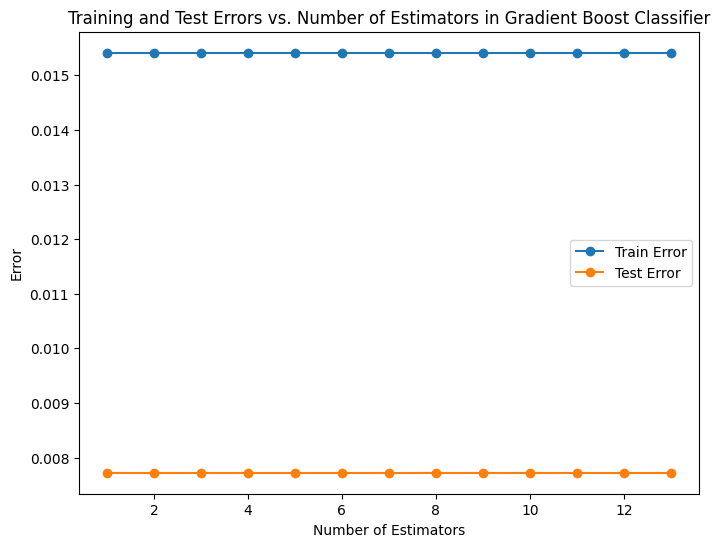

In [ ]:

# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 14):
    gbc.fit(X_train, y_train)
    train_errors.append(1 - gbc.score(X_train, y_train))
    test_errors.append(1 - gbc.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 14), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 14), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Estimators in Gradient Boost Classifier')
plt.legend()

#plt.ylim(0, 0.1)
plt.show()

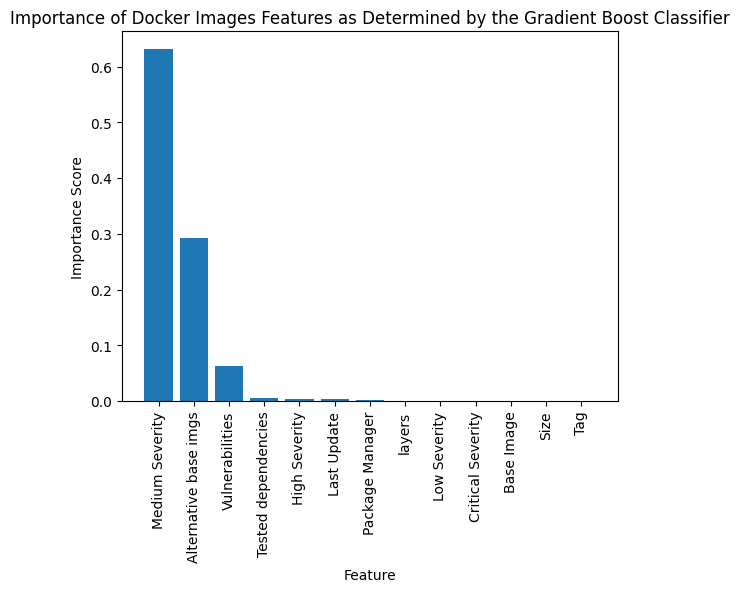

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



# Get feature importances
feature_importances = gbc.feature_importances_

# Get feature names (assuming you have them)
feature_names = ['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       'Alternative base imgs', 'Tested dependencies',
       'Vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers']

# Sort features based on importance
sorted_idx = feature_importances.argsort()[::-1]

# Plotting the feature importances
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Importance of Docker Images Features as Determined by the Gradient Boost Classifier")
plt.show()


### **Neural Network Work**

Epoch 1/20
13/13 [==============================] - 1s 11ms/step - loss: 1.9623 - accuracy: 0.8067 - val_loss: 0.8749 - val_accuracy: 0.7615
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.7157 - accuracy: 0.8376 - val_loss: 0.9964 - val_accuracy: 0.6154
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4901 - accuracy: 0.9253 - val_loss: 0.4013 - val_accuracy: 0.9615
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.2578 - accuracy: 0.9536 - val_loss: 0.7466 - val_accuracy: 0.5538
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9768 - val_loss: 0.4381 - val_accuracy: 0.8231
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.1626 - accuracy: 0.9794 - val_loss: 0.8761 - val_accuracy: 0.3615
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.3898 - accuracy: 0.9562 - val_loss: 0.1762 - val_accuracy: 0.9615
Epoch 8/20
13/13 [=

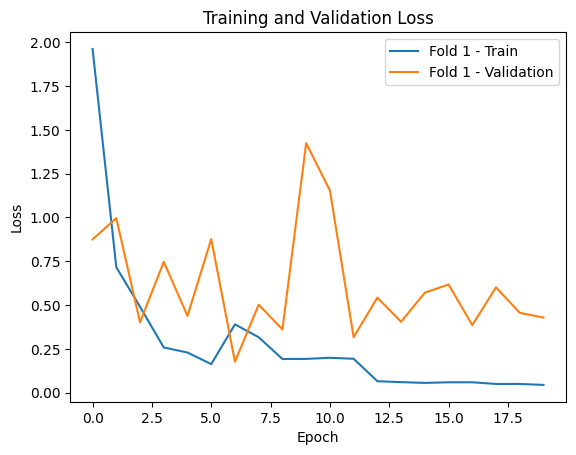

9/9 [==============================] - 0s 1ms/step
Fold 1 - Accuracy: 0.930769
Fold 1 - Precision: 0.947368
Fold 1 - Recall: 0.873786
Fold 1 - F1 Score: 0.909091
Fold 1 - Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       157
         1.0       0.95      0.87      0.91       103

    accuracy                           0.93       260
   macro avg       0.93      0.92      0.93       260
weighted avg       0.93      0.93      0.93       260


Confusion Matrix (Fold 1):
[[152   5]
 [ 13  90]]
True Positives (Fold 1): 90
True Negatives (Fold 1): 152
False Positives (Fold 1): 5
False Negatives (Fold 1): 13
Epoch 1/20
13/13 [==============================] - 1s 16ms/step - loss: 2.1283 - accuracy: 0.7995 - val_loss: 0.7848 - val_accuracy: 0.7462
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 1.0487 - accuracy: 0.8226 - val_loss: 1.2386 - val_accuracy: 0.5462
Epoch 3/20
13/13 [===============

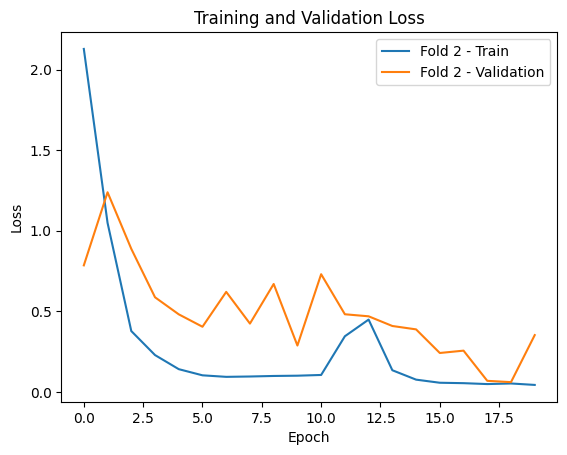

9/9 [==============================] - 0s 1ms/step
Fold 2 - Accuracy: 0.938224
Fold 2 - Precision: 1.000000
Fold 2 - Recall: 0.841584
Fold 2 - F1 Score: 0.913978
Fold 2 - Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       158
         1.0       1.00      0.84      0.91       101

    accuracy                           0.94       259
   macro avg       0.95      0.92      0.93       259
weighted avg       0.94      0.94      0.94       259


Confusion Matrix (Fold 2):
[[158   0]
 [ 16  85]]
True Positives (Fold 2): 85
True Negatives (Fold 2): 158
False Positives (Fold 2): 0
False Negatives (Fold 2): 16
Epoch 1/20
13/13 [==============================] - 1s 12ms/step - loss: 2.7508 - accuracy: 0.7069 - val_loss: 2.3356 - val_accuracy: 0.6846
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 1.0060 - accuracy: 0.8098 - val_loss: 0.8638 - val_accuracy: 0.7462
Epoch 3/20
13/13 [===============

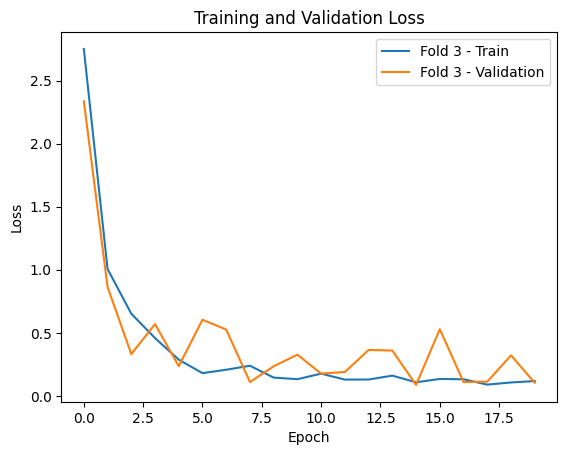

9/9 [==============================] - 0s 1ms/step
Fold 3 - Accuracy: 0.976834
Fold 3 - Precision: 0.962963
Fold 3 - Recall: 0.981132
Fold 3 - F1 Score: 0.971963
Fold 3 - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       153
         1.0       0.96      0.98      0.97       106

    accuracy                           0.98       259
   macro avg       0.97      0.98      0.98       259
weighted avg       0.98      0.98      0.98       259


Confusion Matrix (Fold 3):
[[149   4]
 [  2 104]]
True Positives (Fold 3): 104
True Negatives (Fold 3): 149
False Positives (Fold 3): 4
False Negatives (Fold 3): 2


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# ... (previous code)

# Initialize KFold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert the labels to one-hot encoded format
    y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
    y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

    # Define and compile the model
    model = keras.Sequential([
        keras.layers.Input(shape=(13,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.25)

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label=f'Fold {fold} - Train')
    plt.plot(history.history['val_loss'], label=f'Fold {fold} - Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_labels)
    precision = precision_score(y_test, y_pred_labels)
    recall = recall_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels)
    #auc_value = roc_auc_score(y_test, y_pred[:, 1])

    print(f"Fold {fold} - Accuracy: {accuracy:.6f}")
    print(f"Fold {fold} - Precision: {precision:.6f}")
    print(f"Fold {fold} - Recall: {recall:.6f}")
    print(f"Fold {fold} - F1 Score: {f1:.6f}")
    #print(f"Fold {fold} - AUC: {auc_value:.6f}")

    # Get classification report containing precision, recall, and F1-score
    classification_rep = classification_report(y_test, y_pred_labels)
    print(f"Fold {fold} - Classification Report:\n{classification_rep}\n")


    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Extract TP, TN, FP, FN for the last fold
    tn, fp, fn, tp = conf_matrix.ravel()

    print(f"Confusion Matrix (Fold {fold}):")
    print(conf_matrix)
    print(f"True Positives (Fold {fold}):", tp)
    print(f"True Negatives (Fold {fold}):", tn)
    print(f"False Positives (Fold {fold}):", fp)
    print(f"False Negatives (Fold {fold}):", fn)
    # ... (previous code)

    fold += 1


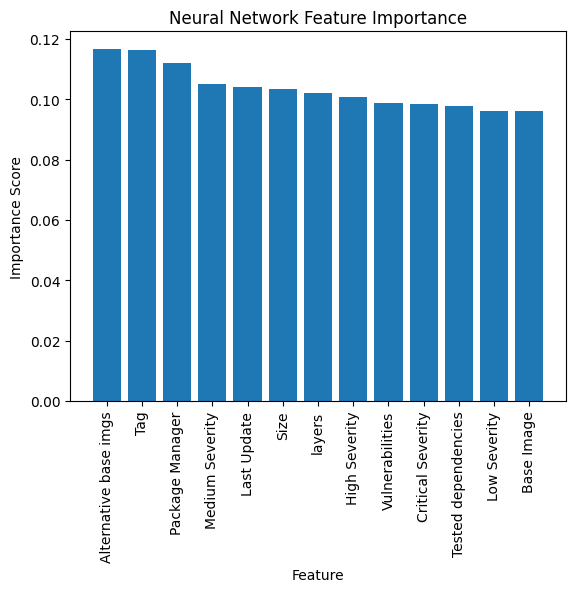

In [ ]:

# Get the weights of the first layer
first_layer_weights = model.layers[0].get_weights()[0]

# Calculate the importance scores by taking the absolute values of the weights
feature_importances = np.abs(first_layer_weights).mean(axis=1)

# Get feature names
feature_names = ['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       'Alternative base imgs', 'Tested dependencies',
       'Vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers']

# Sort features based on importance
sorted_idx = feature_importances.argsort()[::-1]

# Plotting the feature importances
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Neural Network Feature Importance")
plt.show()

### **RANDOM FOREST WORK**

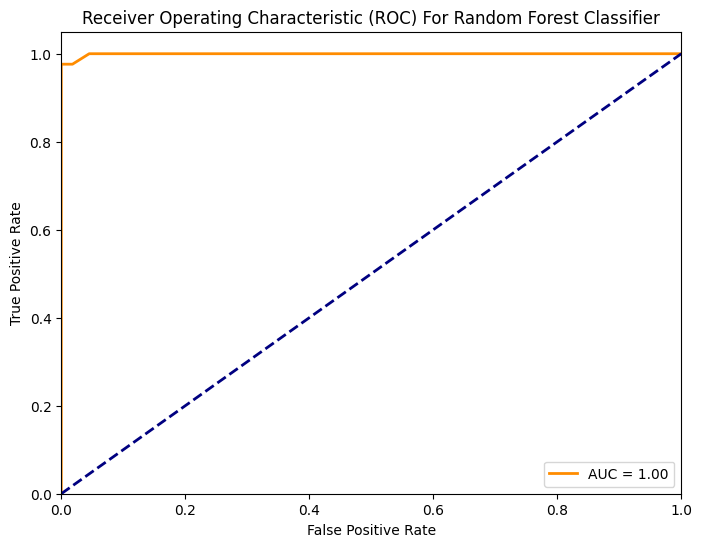

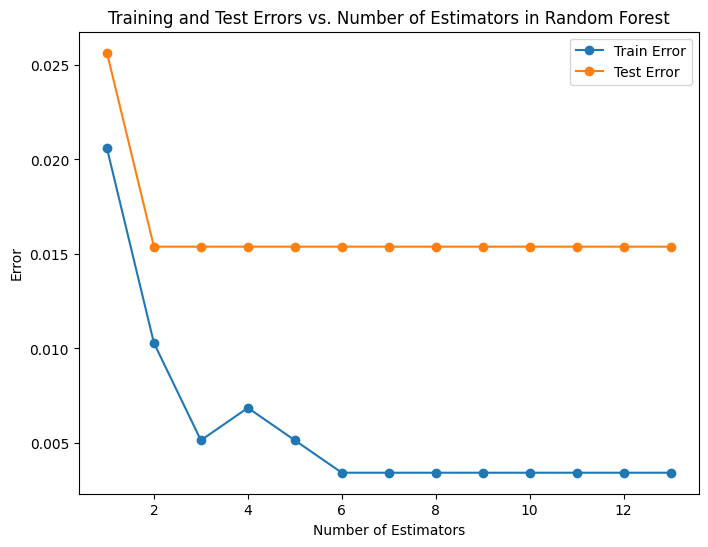

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
rfc = RandomForestClassifier(n_estimators=12, max_depth=13, random_state=SEED)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# ... (other code)
# Calculate the AUC
y_pred_prob = rfc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) For Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 14):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=13, random_state=SEED)
    clf.fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 14), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 14), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Estimators in Random Forest')
plt.legend()
#plt.ylim(0, 0.2)
plt.show()


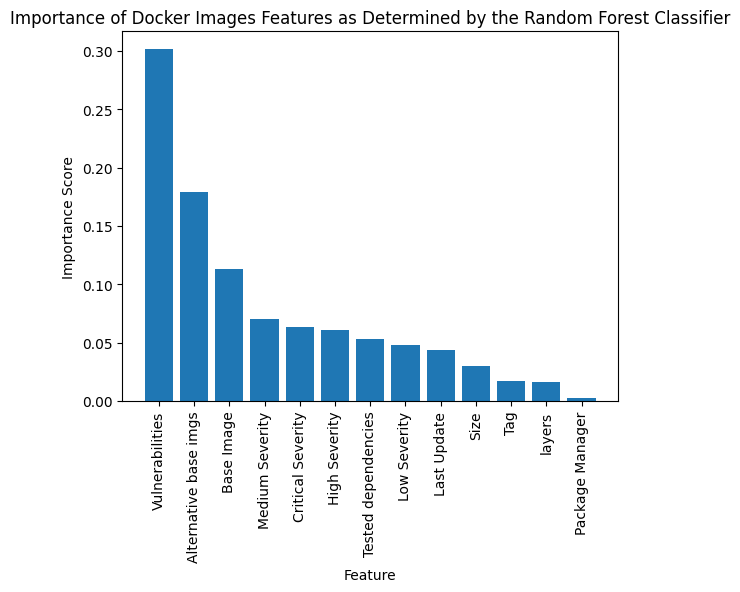

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       111
         1.0       1.00      0.96      0.98        84

    accuracy                           0.98       195
   macro avg       0.99      0.98      0.98       195
weighted avg       0.99      0.98      0.98       195

Accuracy: 0.98
Precision: 1.00
Recall: 0.96
F1 Score: 0.98
True Negatives (TN): 111
False Positives (FP): 0
False Negatives (FN): 3
True Positives (TP): 81


In [ ]:

# Calculate the importance scores by taking the absolute values of the weights
feature_importances =rfc.feature_importances_

# Get feature names
feature_names = ['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       'Alternative base imgs', 'Tested dependencies',
       'Vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers']

# Sort features based on importance
sorted_idx = feature_importances.argsort()[::-1]

# Plotting the feature importances
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Importance of Docker Images Features as Determined by the Random Forest Classifier")
plt.show()


y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

# Calculate the classification metrics with average='weighted'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Extract values from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Print the values
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

In [ ]:
import pickle

# Define a file name for your model
model_filename = 'random_forest_model.pkl'

# Save the model to disk
with open(model_filename, 'wb') as file:
    pickle.dump(rfc, file)

print(f"Model exported as {model_filename}")


Model exported as random_forest_model.pkl


### **XGBoost**

In [ ]:
! pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define the XGBoost model
modelxgb = xgb.XGBClassifier(n_estimators=10, max_depth=13, random_state=SEED)

# Train the model
modelxgb.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = modelxgb.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)




# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

# Extract TP, TN, FP, FN
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix and individual values
print("Confusion Matrix:")
print(conf_matrix)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


Accuracy: 0.99
Accuracy: 0.9922779922779923
Precision: 0.9905660377358491
Recall: 0.9905660377358491
F1-score: 0.9905660377358491
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       153
         1.0       0.99      0.99      0.99       106

    accuracy                           0.99       259
   macro avg       0.99      0.99      0.99       259
weighted avg       0.99      0.99      0.99       259

Confusion Matrix:
[[152   1]
 [  1 105]]

True Positives: 105
True Negatives: 152
False Positives: 1
False Negatives: 1


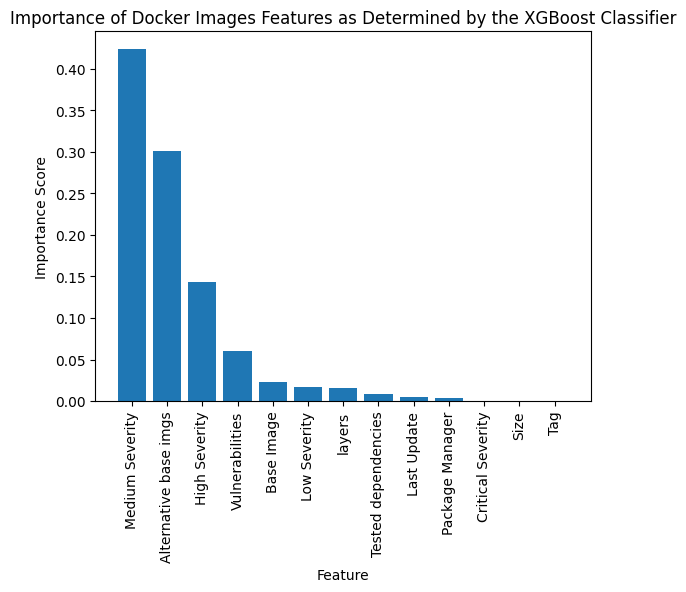

In [ ]:

# Calculate the importance scores by taking the absolute values of the weights
feature_importances =modelxgb.feature_importances_

# Get feature names
feature_names = ['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       'Alternative base imgs', 'Tested dependencies',
       'Vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers']

# Sort features based on importance
sorted_idx = feature_importances.argsort()[::-1]

# Plotting the feature importances
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Importance of Docker Images Features as Determined by the XGBoost Classifier")
plt.show()


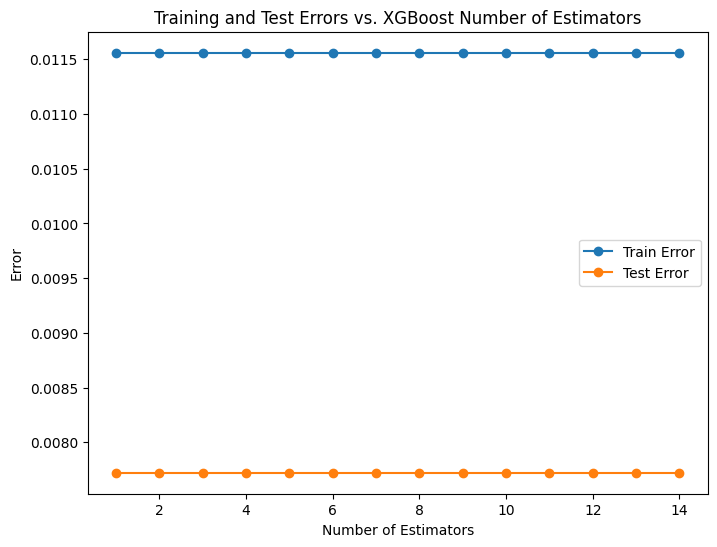

In [ ]:

# Plot training and test errors
train_errors = []
test_errors = []
for n_estimators in range(1, 15):

    modelxgb.fit(X_train, y_train)
    train_errors.append(1 - modelxgb.score(X_train, y_train))
    test_errors.append(1 - modelxgb.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 15), train_errors, label='Train Error', marker='o')
plt.plot(range(1, 15), test_errors, label='Test Error', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. XGBoost Number of Estimators')
plt.legend()
#plt.ylim(0, 0.2)

plt.show()

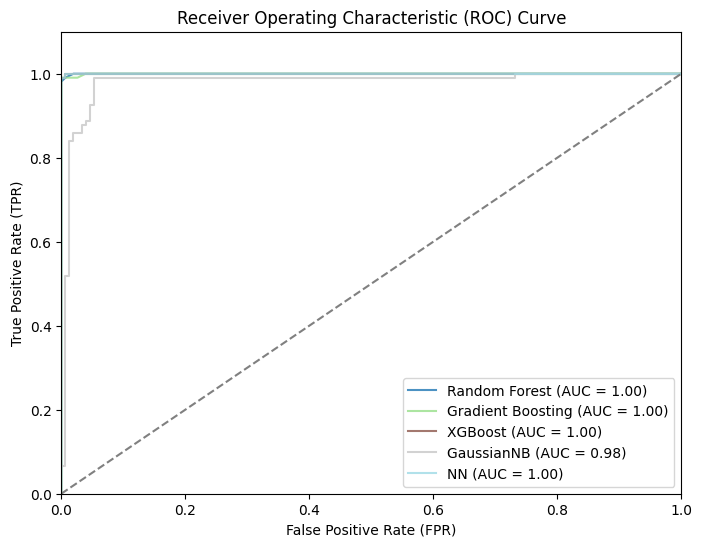

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define classifiers
classifiers = {
    "Random Forest":rfc,
    "Gradient Boosting":gbc,
    "XGBoost": modelxgb,
    "GaussianNB": nb,
    "NN": model
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Create empty lists to store fpr and tpr values for each classifier
fpr_values = {}
tpr_values = {}

# Split the data into training and test sets

# Convert the labels to one-hot encoded format

# Initialize a color map for the ROC curves
colors = iter(plt.cm.tab20(np.linspace(0, 1, len(classifiers))))

# Initialize a figure for the ROC plot
plt.figure(figsize=(8, 6))

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    if clf_name == "NN" or clf_name == "XGBoost":
        auc_values[clf_name] = auc_value
    else:
        auc_values[clf_name] = auc_value

    # Store the fpr and tpr values for each classifier
    fpr_values[clf_name] = fpr
    tpr_values[clf_name] = tpr

# Plot the ROC curves for all classifiers
for clf_name in classifiers:
    auc_value = auc_values[clf_name]
    fpr = fpr_values[clf_name]
    tpr = tpr_values[clf_name]

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})', color=next(colors), alpha=0.8)

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


9/9 [==============================] - 0s 1ms/step


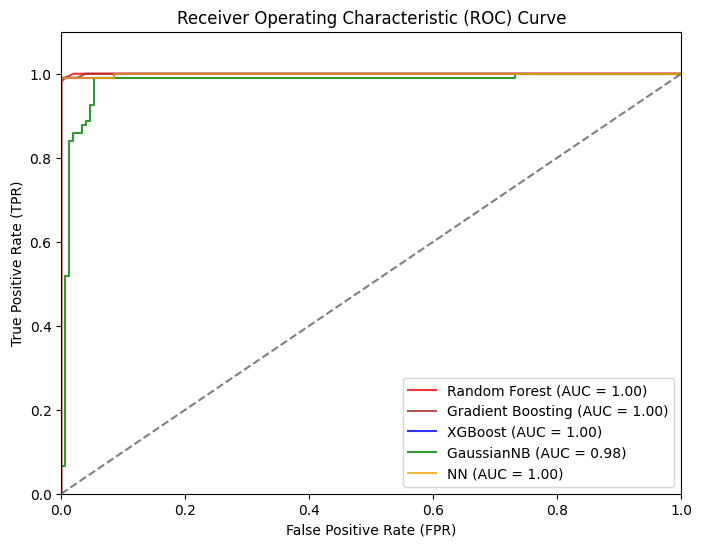

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow import keras

# Define custom colors for each classifier
colors = {
    "Random Forest": 'red',
    "Gradient Boosting": 'brown',
    "XGBoost": 'blue',
    "GaussianNB": 'green',
    "NN": 'orange',
}

# Define classifiers
classifiers = {
    "Random Forest": rfc,
    "Gradient Boosting": gbc,
    "XGBoost": model,
    "GaussianNB": nb,
    "NN": model
}

# Create an empty dictionary to store AUC values
auc_values = {}

# Create empty lists to store fpr and tpr values for each classifier
fpr_values = {}
tpr_values = {}

# Split the data into training and test sets

# Convert the labels to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train, num_classes=2)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes=2)

# Initialize a figure for the ROC plot
plt.figure(figsize=(8, 6))

for clf_name, clf in classifiers.items():
    if isinstance(clf, keras.Sequential):
        # For the Neural Network, compile and train the model
        y_pred = clf.predict(X_test)[:, 1]
    else:
        # For other classifiers, fit and predict as before
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC and store it
    auc_value = auc(fpr, tpr)
    auc_values[clf_name] = auc_value

    # Store the fpr and tpr values for each classifier
    fpr_values[clf_name] = fpr
    tpr_values[clf_name] = tpr

# Plot the ROC curves for all classifiers
for clf_name in classifiers:
      auc_value = auc_values[clf_name]
      fpr = fpr_values[clf_name]
      tpr = tpr_values[clf_name]

      plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc_value:.2f})', color=colors[clf_name], alpha=0.8)

# Plot formatting and legend
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


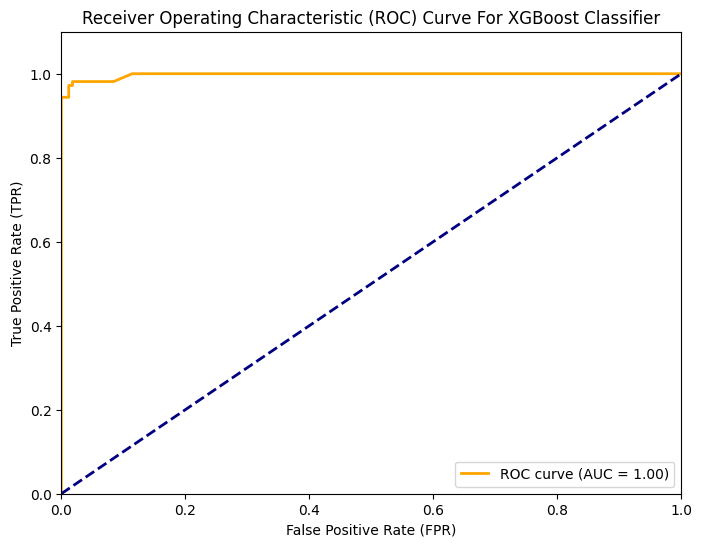

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict the probabilities of the positive class
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve For XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()


### **GaussianNB**

In [ ]:
# Import the necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Naive Bayes classifier object
nb = GaussianNB()

# Train the classifier using the training data
nb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)
y_pred= np.where(y_pred > 0.5, 1, 0)
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Extract TP, TN, FP, FN
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix and individual values
print("Confusion Matrix:")
print(conf_matrix)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


Accuracy: 0.9575289575289575
Accuracy: 0.9575289575289575
Precision: 0.9130434782608695
Recall: 0.9905660377358491
F1-score: 0.9502262443438914
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       153
         1.0       0.91      0.99      0.95       106

    accuracy                           0.96       259
   macro avg       0.95      0.96      0.96       259
weighted avg       0.96      0.96      0.96       259

Confusion Matrix:
[[143  10]
 [  1 105]]

True Positives: 105
True Negatives: 143
False Positives: 10
False Negatives: 1


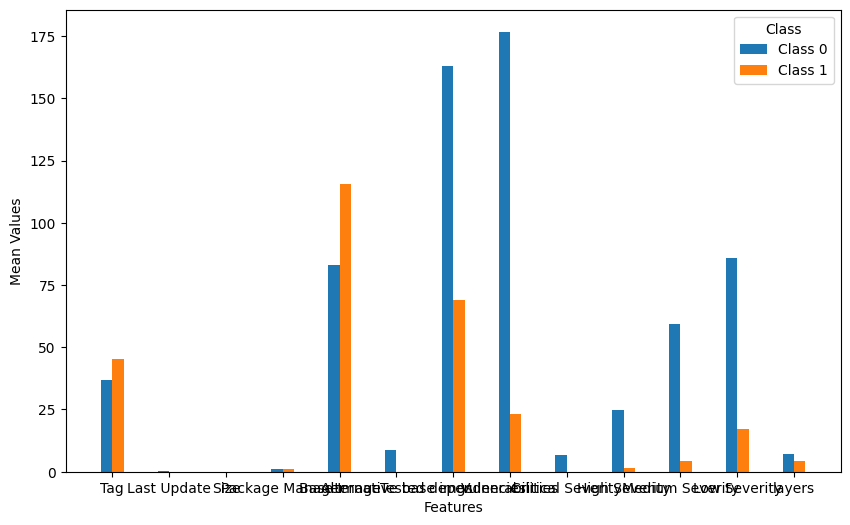

In [ ]:

# Access means of each feature for each class
means = nb.theta_
feature_names = ['Tag', 'Last Update', 'Size', 'Package Manager', 'Base Image',
       'Alternative base imgs', 'Tested dependencies',
       'Vulnerabilities', 'Critical Severity', 'High Severity',
       'Medium Severity', 'Low Severity', 'layers']

# Plot the means for each feature and class in a grouped bar chart
num_features = len(feature_names)
num_classes = len(np.unique(y))

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
bar_positions = np.arange(num_features)

for class_label in range(num_classes):
    ax.bar(bar_positions + bar_width * class_label, means[class_label], width=bar_width, label=f'Class {class_label}')

ax.set_xticks(bar_positions + bar_width * (num_classes - 1) / 2)
ax.set_xticklabels(feature_names)
ax.legend(title='Class')
ax.set_xlabel('Features')
ax.set_ylabel('Mean Values')

plt.show()